In [2]:
import cv2
import random
import pandas as pd
import numpy as np
import time
from tqdm import tqdm
from pathlib import Path
from os import getenv
import itertools

# Deep Learning using Keras
from keras.layers import Conv2D, Dense, Dropout, Flatten
from keras.models import Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
#from keras.utils import print_summary
%matplotlib inline
from tensorflow.python.keras.utils.layer_utils import print_summary

In [3]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Image Preprocessing
from skimage.transform import resize
from skimage.color import rgb2gray

# Set random seeds so results are the same each time
#np.random.seed(0)
#from tensorflow import set_random_seed
#set_random_seed(0)
import tensorflow
np.random.seed(0)
#from tensorflow import set_random_seed
#set_random_seed(0)
tensorflow.random.set_seed(0)

In [4]:
TRAIN_DIR = '../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/'
FILE_PATTERN = TRAIN_DIR + '{letter}/{letter}{index}.jpg'

In [5]:
FULL_TRAIN_SIZE = 3000
MINI_TRAIN_SIZE = 100

# Define the classes (letters of the ASL alphabet) that are being analyzed.
LETTERS = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P',
           'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']

# Define a hash table (dict) to store labels
LABEL_DICT = dict(zip(LETTERS, np.arange(1, 30)))

# Image sizing
IMAGE_SIZE = 50

In [6]:
def plot_confusion_matrix(cm, classes,
                      normalize=False,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues):
    '''
    Plot a confusion matrix heatmap using matplotlib. This code was obtained from
    the scikit-learn documentation:

    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return

In [7]:
def plot_confusion_matrix_with_default_options(y_pred, y_true, classes):
    '''Plot a confusion matrix heatmap with a default size and default options.'''
    cm = confusion_matrix(y_true, y_pred)
    with sns.axes_style('ticks'):
        plt.figure(figsize=(16, 16))
        plot_confusion_matrix(cm, classes)
        plt.show()
    return

In [8]:
def get_data(indices):
    '''Read data into two numpy arrays.'''
    xdata = []
    ydata = []

    for letter in LETTERS:
        for index in indices:
            # Create label
            ydata.append(LABEL_DICT[letter])

            # Read original image
            image_path = FILE_PATTERN.format(letter=letter, index=index)
            img_file = cv2.imread(image_path)

            if img_file is None:
                continue
            img_file = resize(img_file, (IMAGE_SIZE, IMAGE_SIZE, 3))

            # Append to data array
            xdata.append(np.asarray(img_file))

    xdata = np.asarray(xdata)
    ydata = np.asarray(ydata)
    return xdata, ydata

In [9]:
INDEX_LIST = np.arange(1, 3001)
TRAIN_INDICES, DEV_INDICES = train_test_split(
    INDEX_LIST,
    train_size=MINI_TRAIN_SIZE,
    test_size=MINI_TRAIN_SIZE,
    random_state=42)
X_MINI_TRAIN_ORIG, Y_MINI_TRAIN = get_data(TRAIN_INDICES)
X_DEV_ORIG, Y_DEV = get_data(DEV_INDICES)

print('Initial shape of training data:', X_MINI_TRAIN_ORIG.shape)
print('Initial shape of dev data:', X_DEV_ORIG.shape)

Initial shape of training data: (2900, 50, 50, 3)
Initial shape of dev data: (2900, 50, 50, 3)


In [10]:
NSAMPLES, NX, NY, NZ = X_MINI_TRAIN_ORIG.shape
X_MINI_TRAIN = X_MINI_TRAIN_ORIG[:NSAMPLES, :, :, :].reshape(NSAMPLES, 7500)
Y_MINI_TRAIN = Y_MINI_TRAIN[:NSAMPLES]

NSAMPLES_DEV, NX, NY, NZ = X_DEV_ORIG.shape
X_DEV = X_DEV_ORIG[:NSAMPLES_DEV, :, :, :].reshape(NSAMPLES_DEV, 7500)
Y_DEV = Y_DEV[:NSAMPLES_DEV]

print('Current shape of training data:', X_MINI_TRAIN.shape)
print('Current shape of dev data:', X_DEV.shape)

Current shape of training data: (2900, 7500)
Current shape of dev data: (2900, 7500)


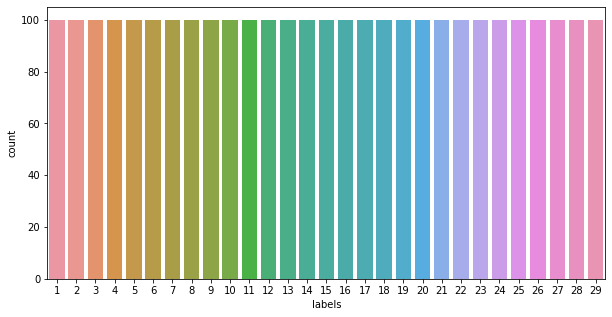

In [11]:
def show_class_counts():
    df = pd.DataFrame(Y_MINI_TRAIN, columns=['labels'])
    df['count'] = 1
    pd.pivot_table(df, columns='labels', values='count',
                   aggfunc=np.count_nonzero)

    plt.subplots(figsize=(10, 5))
    sns.countplot(df['labels'])
    return


show_class_counts()

In [12]:
def plot_examples(num_examples):
    plt.figure(figsize=(16, len(LETTERS) * 2))

    plot_index = 0
    for counter in np.unique(Y_MINI_TRAIN):
        x2 = X_MINI_TRAIN_ORIG[np.where(Y_MINI_TRAIN == counter)[0]]
        y2 = Y_MINI_TRAIN[np.where(Y_MINI_TRAIN == counter)[0]]

        for _, (image, label) in enumerate(zip(x2[0:num_examples], y2[0:num_examples])):
            plot_index += 1
            plt.subplot(len(LETTERS), num_examples, plot_index)
            plt.imshow(image, cmap=plt.cm.gray)
            plt.title(LETTERS[label - 1])
            plt.axis('off')

    return

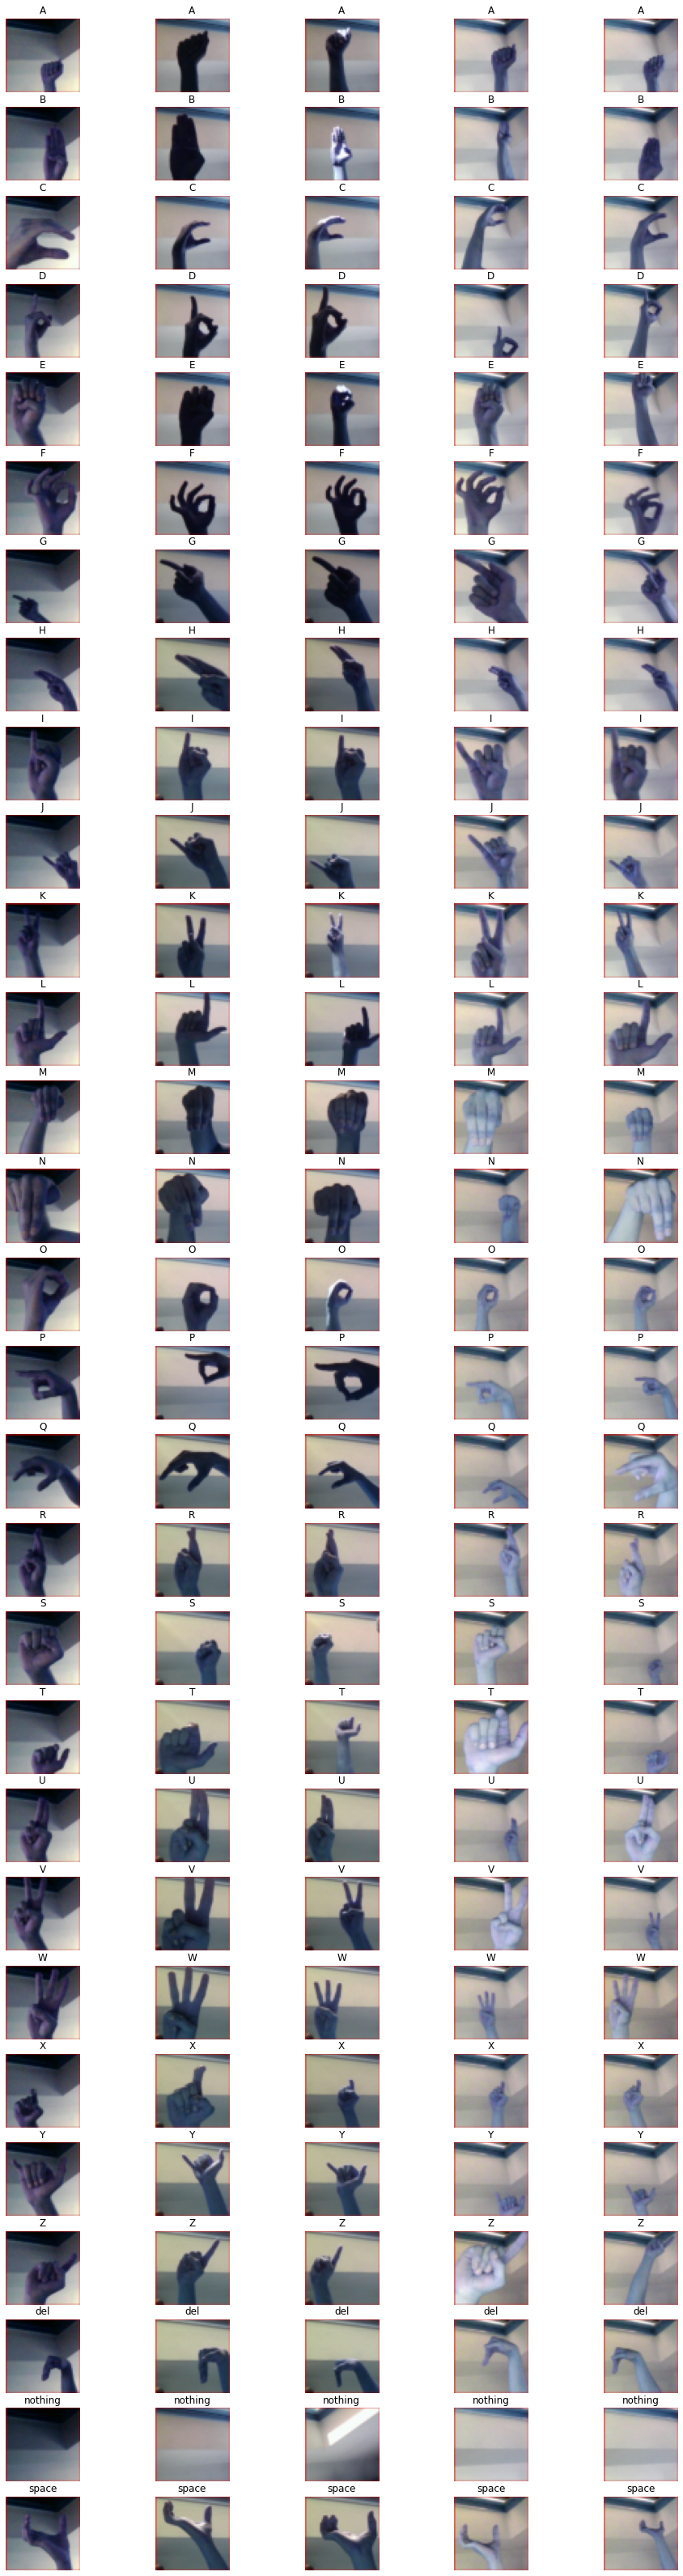

In [13]:
plot_examples(5)

In [14]:
def plot_symbol(symbol, examples):
    label = LETTERS.index(symbol)
    data = X_MINI_TRAIN_ORIG[np.where(Y_MINI_TRAIN == label)]
    img_arr = data[random.sample(range(0, data.shape[0]-1), examples)]
    fig, ax = plt.subplots(nrows=examples, ncols=4,
                           sharex=True, sharey=True, figsize=(10, 20))
    title = "Subplots of " + LETTERS[label]
    fig.suptitle(title, fontsize=30, y=0.93)
    for i in range(examples):
        data_all = img_arr[i, :, :, :]
        data_red = img_arr[i, :, :, 0]
        data_green = img_arr[i, :, :, 1]
        data_blue = img_arr[i, :, :, 2]

        ax[i][0].imshow(data_all)
        ax[i][0].set_title("Original")
        ax[i][0].axis('off')

        ax[i][1].imshow(data_red)
        ax[i][1].set_title("Red")
        ax[i][1].axis('off')

        ax[i][2].imshow(data_green)
        ax[i][2].set_title("Green")
        ax[i][2].axis('off')
        
        ax[i][3].imshow(data_blue)
        ax[i][3].set_title("Blue")
        ax[i][3].axis('off')
    return

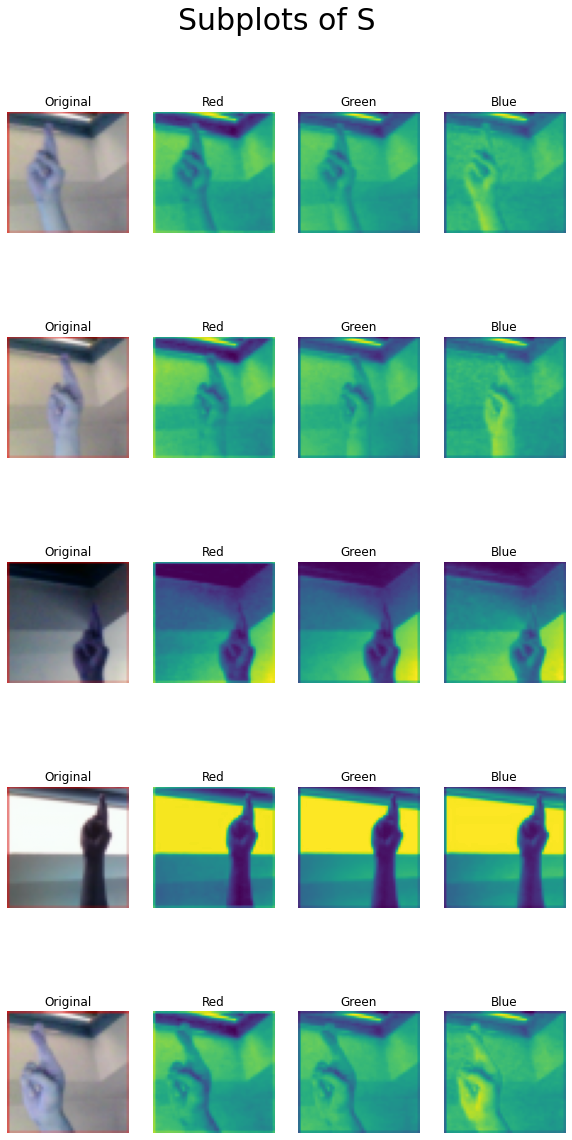

In [15]:
plot_symbol('S', 5)

In [16]:
NSAMPLES, NX, NY, _ = X_MINI_TRAIN_ORIG.shape
X_RED_MINI_TRAIN = X_MINI_TRAIN_ORIG[:NSAMPLES, :, :, 0].reshape(
    NSAMPLES, 2500)
X_GREEN_MINI_TRAIN = X_MINI_TRAIN_ORIG[:NSAMPLES, :, :, 1].reshape(
    NSAMPLES, 2500)
X_BLUE_MINI_TRAIN = X_MINI_TRAIN_ORIG[:NSAMPLES, :, :, 2].reshape(
    NSAMPLES, 2500)

print("X_RED_MINI_TRAIN Shape:", X_RED_MINI_TRAIN.shape)
print("X_GREEN_MINI_TRAIN Shape:", X_GREEN_MINI_TRAIN.shape)
print("X_BLUE_MINI_TRAIN Shape:", X_BLUE_MINI_TRAIN.shape)

# Reshape dev data
NSAMPLES_DEV, _, _, _ = X_DEV_ORIG.shape
X_RED_DEV = X_DEV_ORIG[:NSAMPLES_DEV, :, :, 0].reshape(NSAMPLES_DEV, 2500)
X_GREEN_DEV = X_DEV_ORIG[:NSAMPLES_DEV, :, :, 1].reshape(NSAMPLES_DEV, 2500)
X_BLUE_DEV = X_DEV_ORIG[:NSAMPLES_DEV, :, :, 2].reshape(NSAMPLES_DEV, 2500)

X_RED_MINI_TRAIN Shape: (2900, 2500)
X_GREEN_MINI_TRAIN Shape: (2900, 2500)
X_BLUE_MINI_TRAIN Shape: (2900, 2500)


In [17]:
def blur(data):
    blurred_data_set = np.zeros((data.shape))
    for i in range(data.shape[0]):
        blur_matrix = np.zeros((50, 50))
        test_matrix = np.reshape(data[i], (50, 50))
        for j in range(1, 49):
            for k in range(1, 49):
                blur_matrix[j][k] = (test_matrix[j-1][k-1] + test_matrix[j-1][k]
                                     + test_matrix[j][k] + test_matrix[j-1][k+1] + test_matrix[j][k-1]
                                     + test_matrix[j][k+1] + test_matrix[j+1][k-1] + test_matrix[j+1][k]
                                     + test_matrix[j+1][k+1]) / 9
        blur_matrix = np.reshape(blur_matrix, (2500))
        blurred_data_set[i] = blur_matrix
    return blurred_data_set

In [18]:
BLUR_RED_MINI_TRAIN = blur(X_RED_MINI_TRAIN)
BLUR_RED_DEV = blur(X_RED_DEV)

BLUR_GREEN_MINI_TRAIN = blur(X_GREEN_MINI_TRAIN)
BLUR_GREEN_DEV = blur(X_GREEN_DEV)

BLUR_BLUE_MINI_TRAIN = blur(X_BLUE_MINI_TRAIN)
BLUR_BLUE_DEV = blur(X_BLUE_DEV)

In [19]:
X_BLUR = np.stack(
    [BLUR_RED_MINI_TRAIN, BLUR_GREEN_MINI_TRAIN, BLUR_BLUE_MINI_TRAIN], axis=2)
X_BLUR_DEV = np.stack([BLUR_RED_DEV, BLUR_GREEN_DEV, BLUR_BLUE_DEV], axis=2)
X_BLUR_MINI_TRAIN = X_BLUR.reshape(NSAMPLES, 7500)
X_BLUR_DEV = X_BLUR_DEV.reshape(NSAMPLES_DEV, 7500)

In [20]:
def auto_canny(image, sigma=0.33):
    v = np.median(image)  
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper) 
    return edged

In [21]:
def get_data2(indices):
    nrows = 1
    ncols = 8

    xdata = []
    ydata = []

    for letter in LETTERS:
        for index in indices:
            ydata.append(LABEL_DICT[letter])
            image_path = FILE_PATTERN.format(letter=letter, index=index)
            image = cv2.imread(image_path)
            blurred = cv2.GaussianBlur(image, (5, 5), 0)
            imgray = cv2.cvtColor(blurred, cv2.COLOR_RGB2HSV)
            imgray2 = cv2.medianBlur(imgray, 5)
            resized = imgray2
            resized2 = rgb2gray(resized)
            edge_t = cv2.Canny(resized, 100, 250)
            edge_a = auto_canny(resized)
            resized2 = rgb2gray(edge_t)
            xdata.append(np.asarray(resized2))
        plt.figure(figsize=(16, 5))
        plots = {
            'Original {}'.format(letter): image,
            'Gaussian Blur': blurred,
            'HSV': imgray,
            'Median blur': imgray2,
            'Resized': resized,
            'Tight edged': edge_t,
            'Auto edged': edge_a,
            'Edged grayscale': edge_a,
        }

        plot_index = 0
        for name, image in plots.items():
            plot_index += 1
            plt.subplot(nrows, ncols, plot_index)
            plt.imshow(image)
            plt.title("Original " + letter)
            plt.axis('off')

        plt.show()

    return xdata, ydata

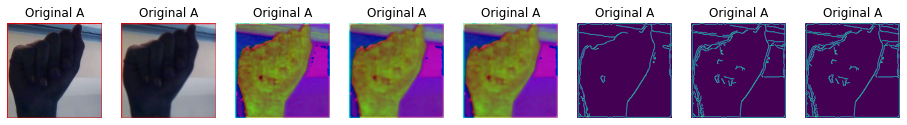

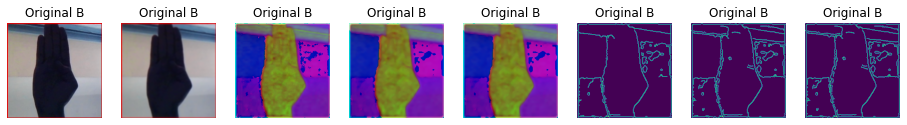

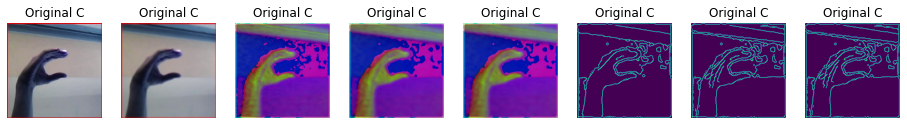

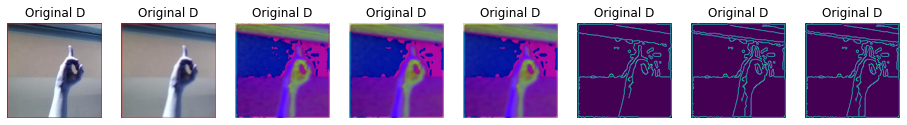

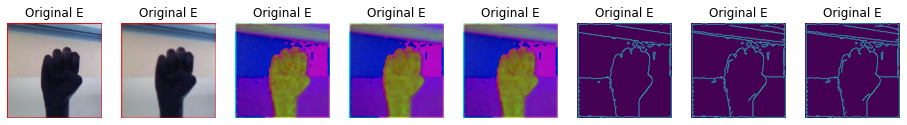

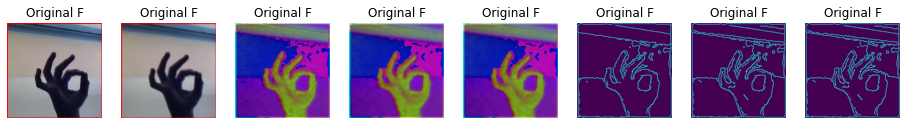

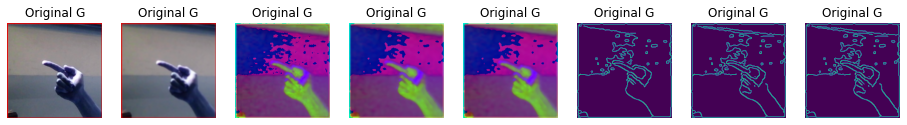

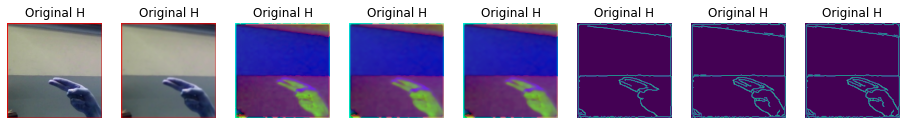

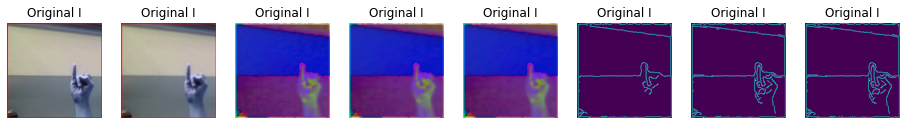

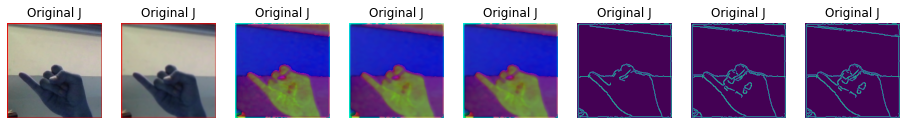

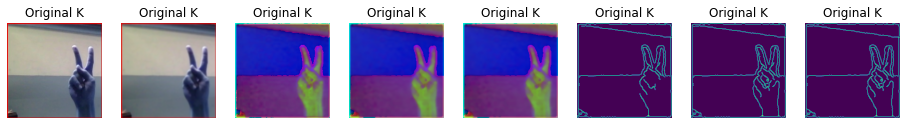

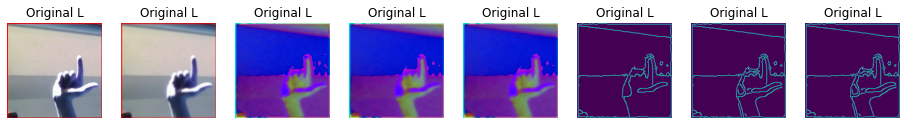

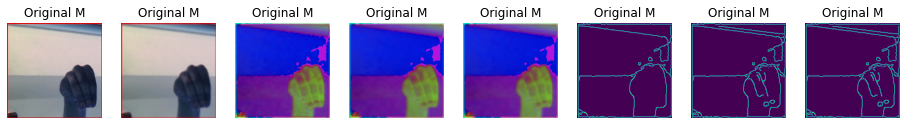

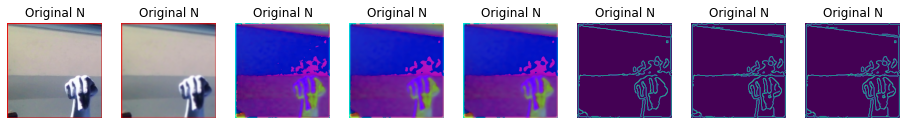

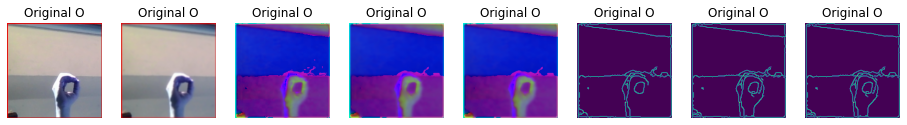

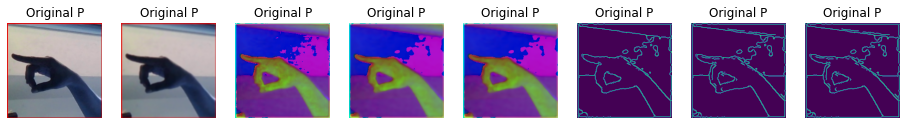

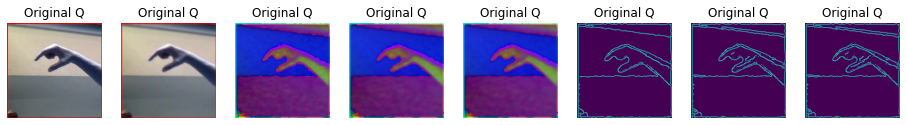

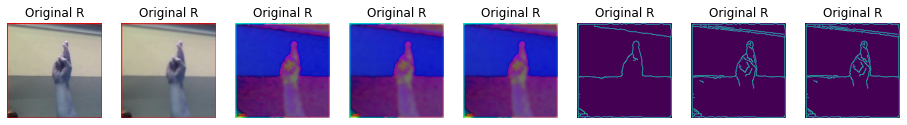

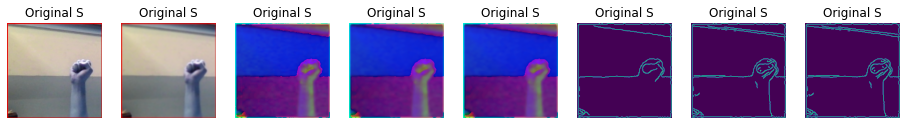

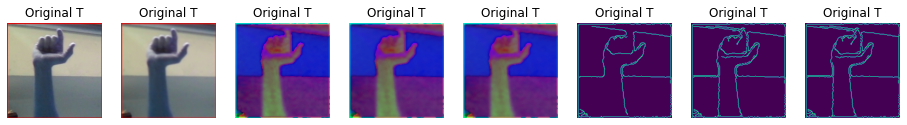

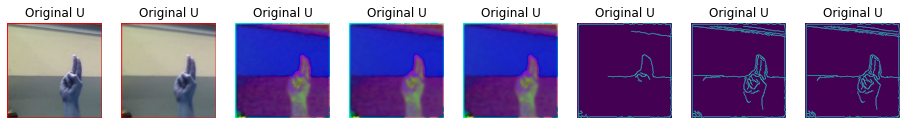

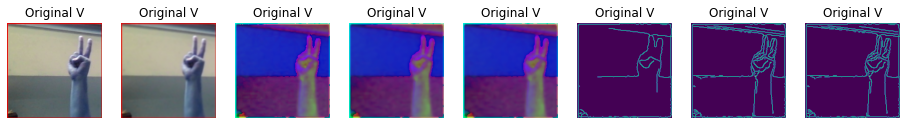

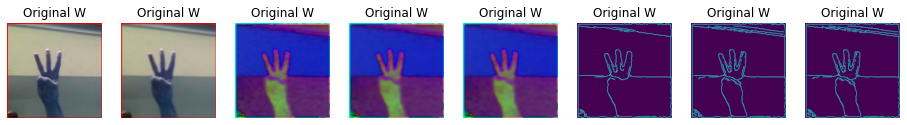

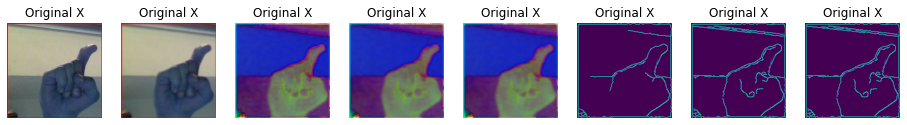

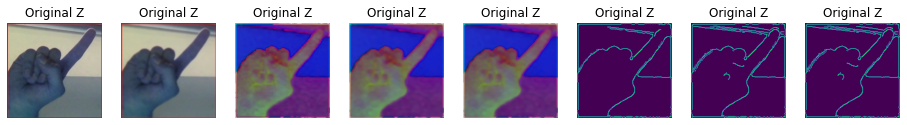

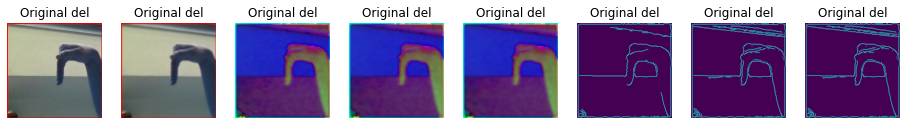

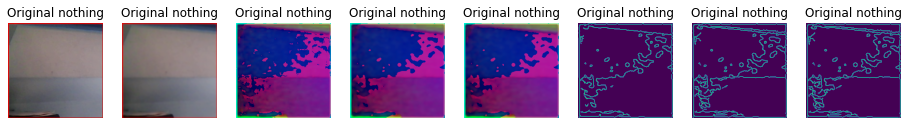

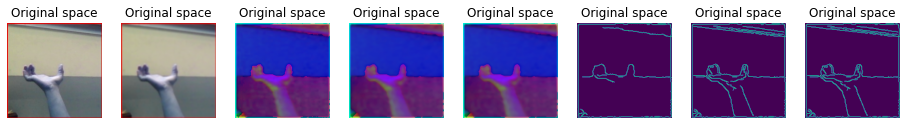

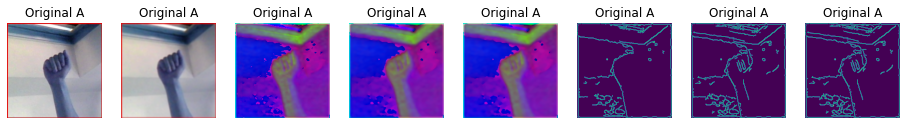

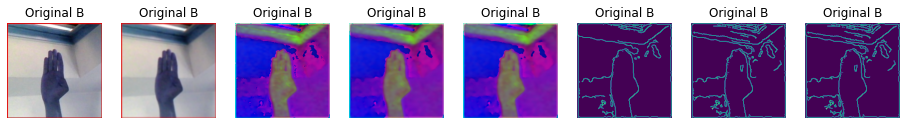

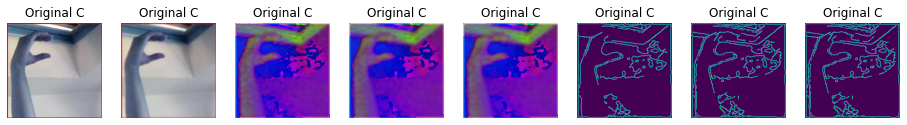

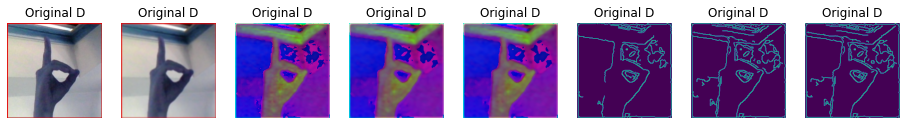

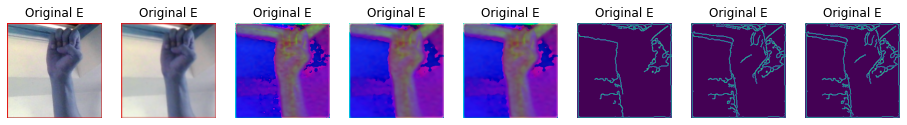

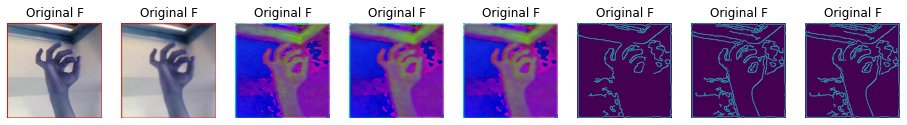

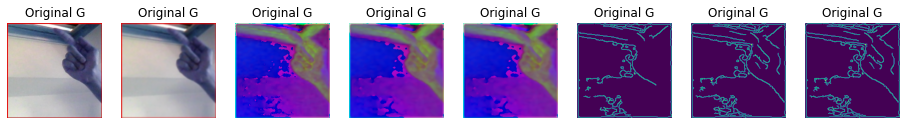

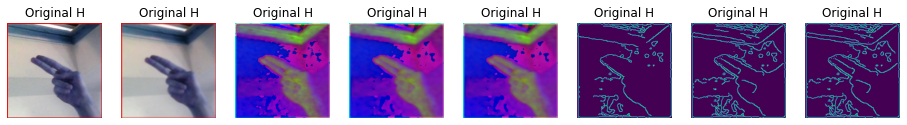

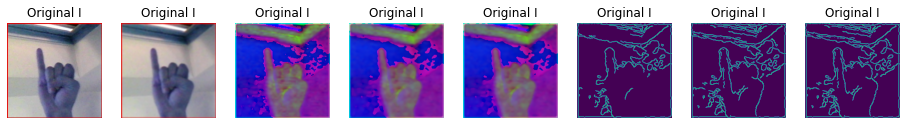

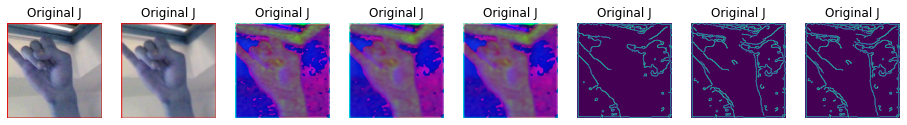

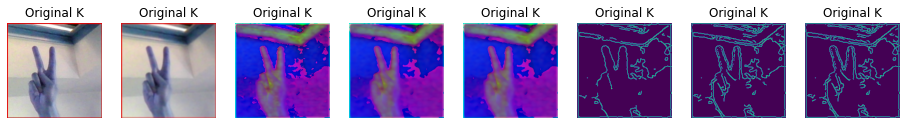

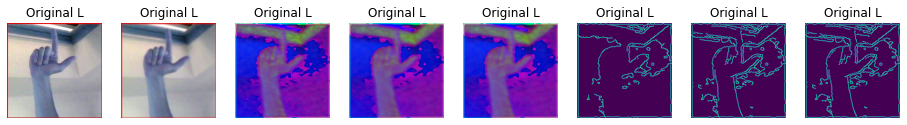

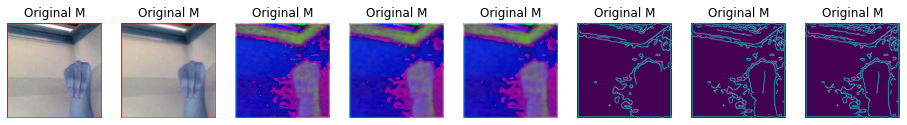

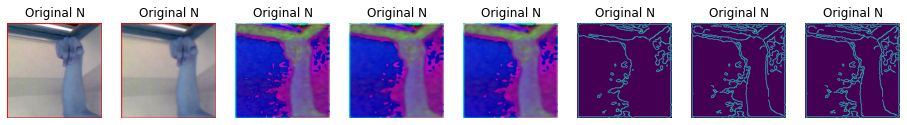

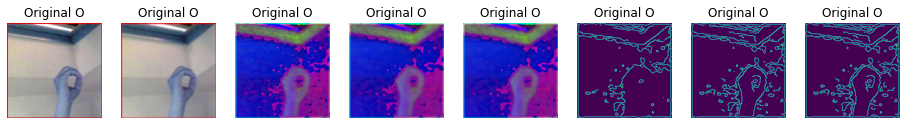

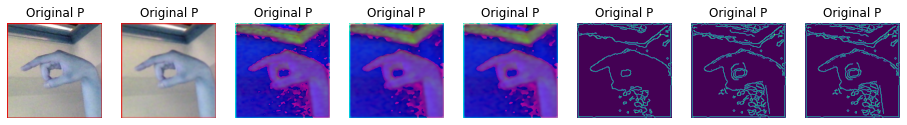

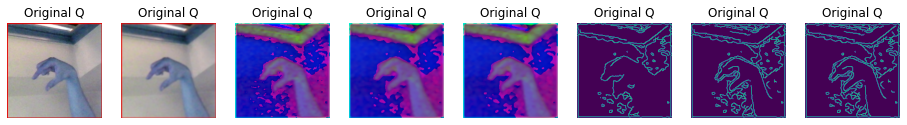

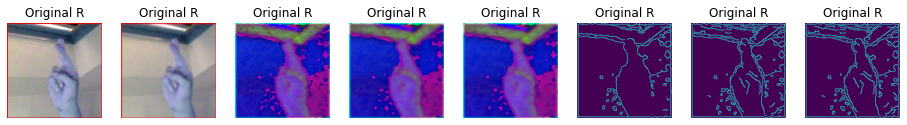

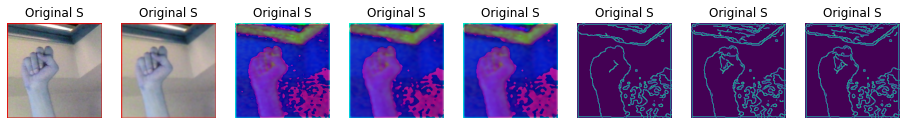

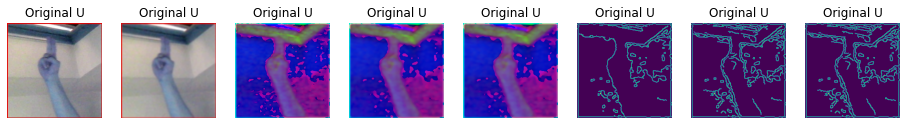

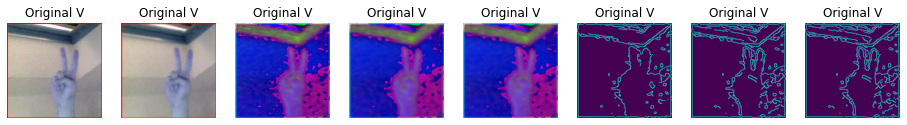

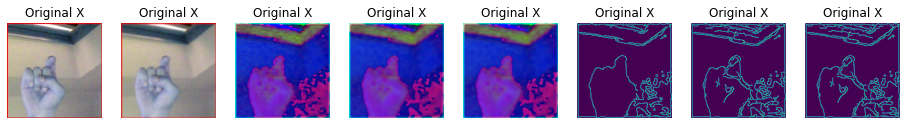

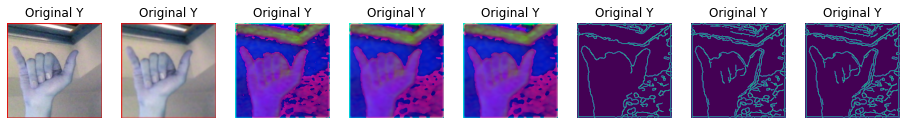

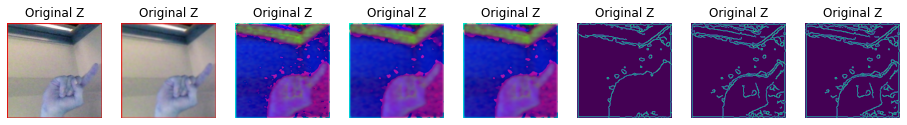

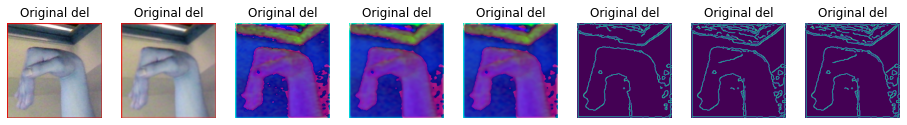

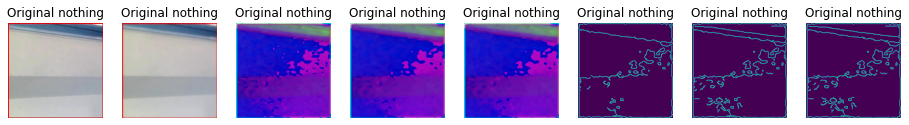

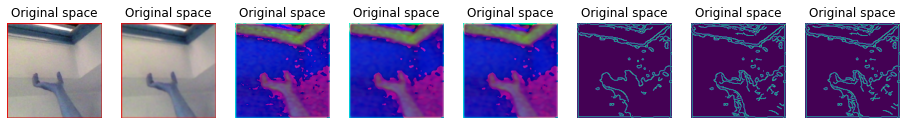

In [22]:
X_IMAGE_MINI_TRAIN_ORIG, Y_TRAIN = get_data2(TRAIN_INDICES)
X_IMAGE_DEV_ORIG, Y_DEV = get_data2(DEV_INDICES)

X_IMAGE_MINI_TRAIN_ORIG = np.asarray(X_IMAGE_MINI_TRAIN_ORIG)
X_IMAGE_DEV_ORIG = np.asarray(X_IMAGE_DEV_ORIG)

In [23]:
NSAMPLES, NX, NY = X_IMAGE_MINI_TRAIN_ORIG.shape
X_IMAGE_MINI_TRAIN = X_IMAGE_MINI_TRAIN_ORIG[:NSAMPLES, :, :].reshape(NSAMPLES, NX * NY)

In [24]:
NSAMPLES_DEV, NX, NY = X_IMAGE_DEV_ORIG.shape
X_IMAGE_DEV = X_IMAGE_DEV_ORIG[:NSAMPLES_DEV, :, :].reshape(NSAMPLES_DEV, NX * NY)

In [25]:
N_COMPONENTS = 110

def reduce_dimensionality(model, data):
    '''Reduce dimensionality with PCA.'''
    n_components = 110
    model.fit(data)
    i = [1] + list(range(10, n_components + 1, 10))
    df = pd.DataFrame(
        index=i, columns=["num_components", "cum_pct_variance"])
    for k in i:
        df.loc[k] = [k, sum(model.explained_variance_ratio_[:k])]

    return df


PCA_MODEL = PCA(n_components=N_COMPONENTS, random_state=0)
DF_PCA = reduce_dimensionality(PCA_MODEL, X_MINI_TRAIN)

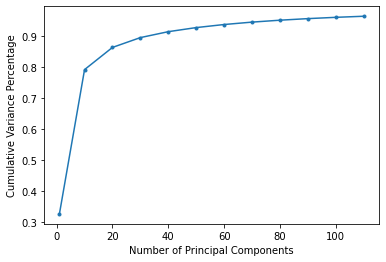

In [26]:
def plot_pca(df):
    plt.plot(df['num_components'], df['cum_pct_variance'], marker='.')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Variance Percentage')
    plt.show()
    return


plot_pca(DF_PCA)

In [27]:
X_MINI_TRAIN_PCA = PCA_MODEL.transform(X_MINI_TRAIN)
X_DEV_PCA = PCA_MODEL.transform(X_DEV)


def pca_transform(model, data, data_pca):
    model.fit(data)
    return model.transform(data_pca)

In [28]:
X_BLUR_MINI_TRAIN_PCA = pca_transform(PCA_MODEL, X_BLUR_MINI_TRAIN, X_BLUR_MINI_TRAIN)
X_BLUR_DEV_PCA = pca_transform(PCA_MODEL, X_BLUR_MINI_TRAIN, X_BLUR_DEV)

X_RED_MINI_TRAIN_PCA = pca_transform(PCA_MODEL, X_RED_MINI_TRAIN, X_RED_MINI_TRAIN)
X_RED_DEV_PCA = pca_transform(PCA_MODEL, X_RED_MINI_TRAIN, X_RED_DEV)
BLUR_RED_MINI_TRAIN_PCA = pca_transform(PCA_MODEL, BLUR_RED_MINI_TRAIN, BLUR_RED_MINI_TRAIN)
BLUR_RED_DEV_PCA = pca_transform(PCA_MODEL, BLUR_RED_MINI_TRAIN, BLUR_RED_DEV)

In [29]:
X_BLUE_MINI_TRAIN_PCA = pca_transform(PCA_MODEL, X_BLUE_MINI_TRAIN, X_BLUE_MINI_TRAIN)
X_BLUE_DEV_PCA = pca_transform(PCA_MODEL, X_BLUE_MINI_TRAIN, X_BLUE_DEV)
BLUR_BLUE_MINI_TRAIN_PCA = pca_transform(PCA_MODEL, BLUR_BLUE_MINI_TRAIN, BLUR_BLUE_MINI_TRAIN)
BLUR_BLUE_DEV_PCA = pca_transform(PCA_MODEL, BLUR_BLUE_MINI_TRAIN, BLUR_BLUE_DEV)

In [30]:
X_GREEN_MINI_TRAIN_PCA = pca_transform(PCA_MODEL, X_GREEN_MINI_TRAIN, X_GREEN_MINI_TRAIN)

X_GREEN_DEV_PCA = pca_transform(PCA_MODEL, X_GREEN_MINI_TRAIN, X_GREEN_DEV)
BLUR_GREEN_MINI_TRAIN_PCA = pca_transform(PCA_MODEL, BLUR_GREEN_MINI_TRAIN, BLUR_GREEN_MINI_TRAIN)
BLUR_GREEN_DEV_PCA = pca_transform(PCA_MODEL, BLUR_GREEN_MINI_TRAIN, BLUR_GREEN_DEV)

In [31]:
def fit_and_tune(traindata, devdata, clf, params_list, clf_name, message, print_cr, print_cm, **kwargs):
    gs = GridSearchCV(estimator=clf, param_grid=params_list, refit=True)
    gs.fit(traindata, Y_MINI_TRAIN)
    print('Tuning parameters for {} for classifier {}'.format(message, clf_name))
    print('Best paramaters:', gs.best_params_)
    print('Best grid score: {:.3f}'.format(gs.best_score_))
    clf.set_params(**gs.best_params_)
    clf.fit(traindata, Y_MINI_TRAIN)
    dev_pred = gs.predict(devdata)
    print("Dev accuracy: ", 100*np.sum(dev_pred == Y_DEV)/devdata.shape[0])

    if print_cr == 1:
        print("Classification Report\n")
        print(classification_report(Y_DEV, dev_pred))

    if print_cm == 1:
        plot_confusion_matrix_with_default_options(
            y_pred=dev_pred,
            y_true=Y_DEV,
            classes=LETTERS)
    return

In [32]:
def fit_and_tune_knn():
    params_list = {'n_neighbors': [1, 5, 10, 15]}
    clf = KNeighborsClassifier()
    clf_name = 'KNN'

    # Call function once on data without PCA and one without:
    fit_and_tune(X_MINI_TRAIN, X_DEV, clf, params_list,
                 clf_name, 'without PCA', 0, 0)
    fit_and_tune(X_MINI_TRAIN_PCA, X_DEV_PCA, clf,
                 params_list, clf_name, 'with PCA', 0, 0)
    return
fit_and_tune_knn()

Tuning parameters for without PCA for classifier KNN
Best paramaters: {'n_neighbors': 1}
Best grid score: 0.623
Dev accuracy:  68.41379310344827
Tuning parameters for with PCA for classifier KNN
Best paramaters: {'n_neighbors': 1}
Best grid score: 0.639
Dev accuracy:  70.13793103448276


In [33]:
TRAINING_SETS = [X_MINI_TRAIN, X_MINI_TRAIN_PCA, X_BLUR_MINI_TRAIN_PCA, X_RED_MINI_TRAIN_PCA, 
                 BLUR_RED_MINI_TRAIN_PCA, X_BLUE_MINI_TRAIN_PCA, BLUR_BLUE_MINI_TRAIN_PCA,
                 X_GREEN_MINI_TRAIN_PCA, BLUR_GREEN_MINI_TRAIN_PCA, X_IMAGE_MINI_TRAIN]
DEVELOPMENT_SETS = [X_DEV, X_DEV_PCA, X_BLUR_DEV_PCA, X_RED_DEV_PCA, BLUR_RED_DEV_PCA, X_BLUE_DEV_PCA,
                    BLUR_BLUE_DEV_PCA, X_GREEN_DEV_PCA, BLUR_GREEN_DEV_PCA, X_IMAGE_DEV]

In [34]:
SET_DESCRIPTIONS = ['No_PCA', 'PCA', 'Blur_PCA', 'Red_PCA', 'Blur_Red_PCA', 'Blue_PCA', 'Blur_Blue_PCA',
                    'Green_PCA', 'Blur_Green_PCA', 'Image_Contour']

In [35]:
KNN_MODEL = KNeighborsClassifier(n_neighbors=1)
print("K Nearest Neighbors Classifier:")


def run_knn(model, training, development, description):
    scores = []
    for train, dev in zip(training, development):
        model.fit(train, Y_MINI_TRAIN)
        scores.append("{:.1%}".format(model.score(dev, Y_DEV)))

    df_knn = pd.DataFrame(columns=['Data Description', 'Accuracy'])
    i = 0
    for desc, score in zip(description, scores):
        df_knn.loc[i] = [desc, score]
        i += 1
    return df_knn


run_knn(KNN_MODEL, TRAINING_SETS, DEVELOPMENT_SETS, SET_DESCRIPTIONS)


K Nearest Neighbors Classifier:


Data Description Accuracy
0           No_PCA    68.4%
1              PCA    70.1%
2         Blur_PCA    70.8%
3          Red_PCA    68.9%
4     Blur_Red_PCA    69.2%
5         Blue_PCA    70.1%
6    Blur_Blue_PCA    70.5%
7        Green_PCA    69.6%
8   Blur_Green_PCA    70.0%
9    Image_Contour    21.8%

In [36]:
KNN_MODEL.fit(X_BLUR_MINI_TRAIN_PCA, Y_MINI_TRAIN)
DEV_PREDICTED_LABELS = KNN_MODEL.predict(X_BLUR_DEV_PCA)
print(classification_report(Y_DEV, DEV_PREDICTED_LABELS))

              precision    recall  f1-score   support

           1       0.58      0.62      0.60       100
           2       0.67      0.76      0.71       100
           3       0.88      0.79      0.83       100
           4       0.72      0.68      0.70       100
           5       0.62      0.66      0.64       100
           6       0.78      0.76      0.77       100
           7       0.83      0.77      0.80       100
           8       0.69      0.85      0.76       100
           9       0.78      0.75      0.77       100
          10       0.85      0.69      0.76       100
          11       0.78      0.72      0.75       100
          12       0.85      0.76      0.80       100
          13       0.64      0.56      0.60       100
          14       0.82      0.71      0.76       100
          15       0.76      0.58      0.66       100
          16       0.83      0.80      0.82       100
          17       0.90      0.78      0.83       100
          18       0.52    

In [37]:
def run_bagged_trees():
    bg = BaggingClassifier(random_state=0)
    bg.fit(X_MINI_TRAIN_PCA, Y_MINI_TRAIN)
    print("Bagged Trees Classifier:\n")
    print("Accuracy with PCA dimensionality reduction:", "{:.1%}".format(bg.score(X_DEV_PCA, Y_DEV)))
    bg = BaggingClassifier(random_state=0)
    bg.fit(X_MINI_TRAIN, Y_MINI_TRAIN)
    print("Accuracy without PCA dimensionality reduction:", "{:.1%}".format(bg.score(X_DEV, Y_DEV)))
    return
    

run_bagged_trees()

Bagged Trees Classifier:

Accuracy with PCA dimensionality reduction: 49.1%
Accuracy without PCA dimensionality reduction: 80.9%


In [38]:
def make_decision_tree():
    leaf_nodes = [100, 500, 800]
    estimators = [10, 20, 30, 50]
    num_leaf_nodes = len(leaf_nodes)
    num_estimators = len(estimators)

    df1 = pd.DataFrame(index=range(num_leaf_nodes*num_estimators),
                       columns=["leaf_nodes", "estimators", "accuracy"])
    for i in range(num_leaf_nodes):
        dt = DecisionTreeClassifier(max_leaf_nodes=leaf_nodes[i])
        for j in range(num_estimators):
            bg = BaggingClassifier(
                base_estimator=dt, n_estimators=estimators[j], random_state=0)
            bg.fit(X_MINI_TRAIN, Y_MINI_TRAIN)
            accuracy = bg.score(X_DEV, Y_DEV)
            df1.loc[(i*num_estimators)+j] = [leaf_nodes[i],
                                             estimators[j], accuracy]

    return df1
BAGGING_DF = make_decision_tree()

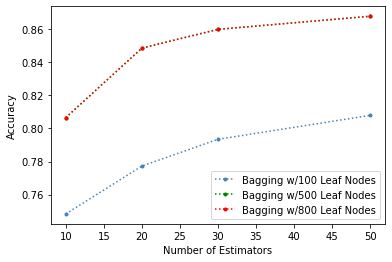

In [39]:
def plot_bagging(df):
    plt.plot(df.loc[0:3]["estimators"], df.loc[0:3]["accuracy"], color='steelblue',
             marker='.', linestyle='dotted', label="Bagging w/100 Leaf Nodes")
    plt.plot(df.loc[4:7]["estimators"], df.loc[4:7]["accuracy"], color='green',
             marker='.', linestyle='dotted', label="Bagging w/500 Leaf Nodes")
    plt.plot(df.loc[8:11]["estimators"], df.loc[8:11]["accuracy"], color='red',
             marker='.', linestyle='dotted', label="Bagging w/800 Leaf Nodes")
    plt.xlabel("Number of Estimators")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()
    return
plot_bagging(BAGGING_DF)

In [40]:
def run_bagged_trees2():
    estimators = [50, 70, 80, 100]
    num_estimators = len(estimators)

    df = pd.DataFrame(index=range(num_estimators),
                       columns=["estimators", "accuracy"])
    for j in range(num_estimators):
        bg = BaggingClassifier(n_estimators=estimators[j], random_state=0)
        bg.fit(X_MINI_TRAIN, Y_MINI_TRAIN)
        accuracy = bg.score(X_DEV, Y_DEV)
        df.loc[j] = [estimators[j], accuracy]

    return df


BAGGING_DF2 = run_bagged_trees2()

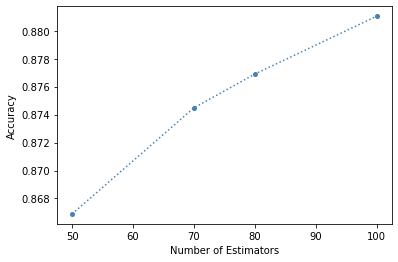

In [41]:
def plot_bagging2(df):
    plt.plot(df["estimators"], df["accuracy"], color='steelblue', marker='.', linestyle='dotted', markersize=8)
    plt.xlabel("Number of Estimators")
    plt.ylabel("Accuracy")
    plt.show()
    return
    
    
plot_bagging2(BAGGING_DF2)

Confusion matrix, without normalization


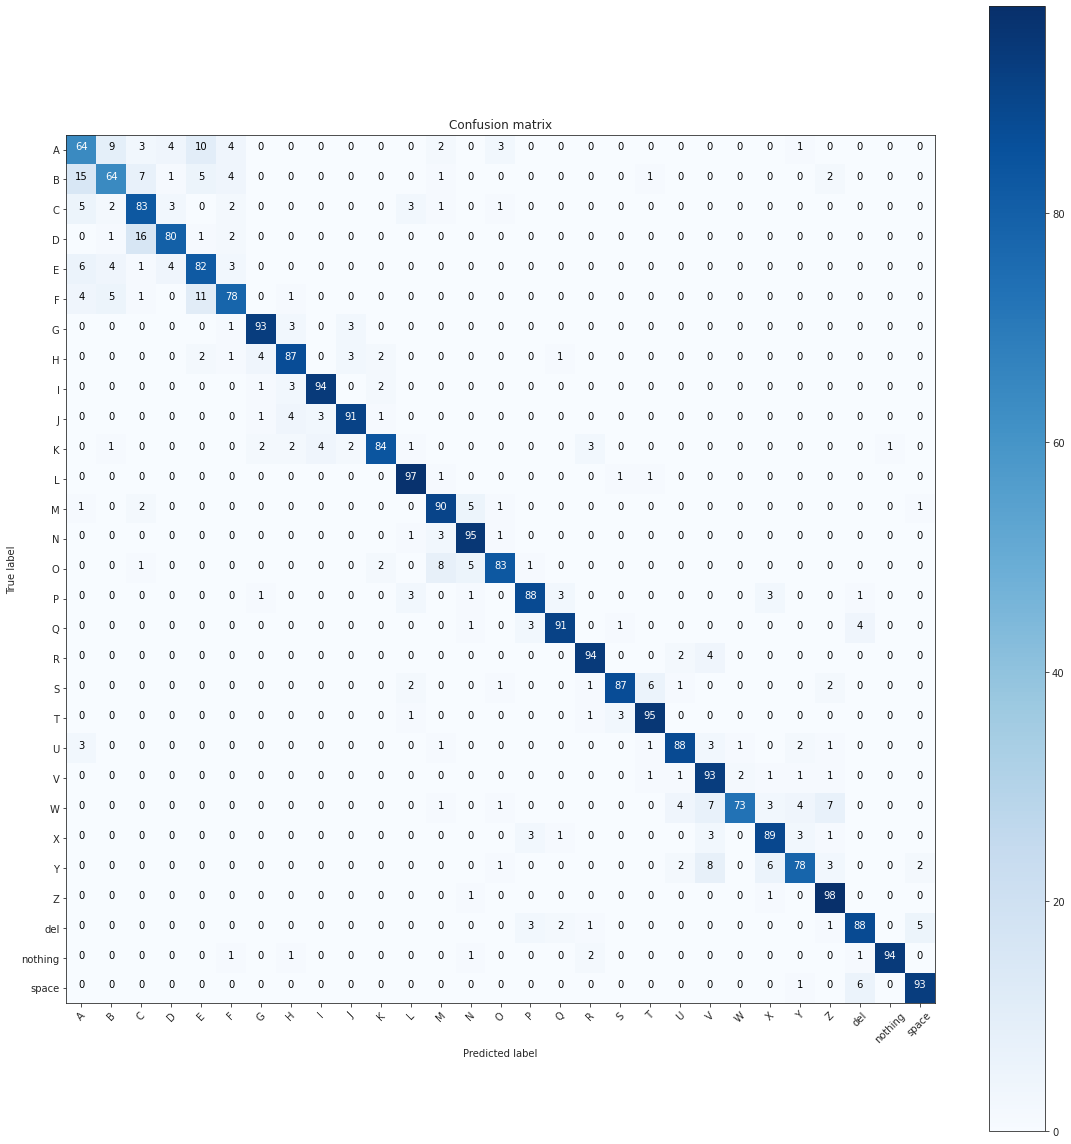

Number of incorrect predictions for each hand-sign: [36 36 17 20 18 22  7 13  6  9 16  3 10  5 17 12  9  6 13  5 12  7 27 11
 22  2 12  6  7] 

Maximum number of incorrect predictions for each hand-sign: [10 15  5 16  6 11  3  4  3  4  4  1  5  3  8  3  4  4  6  3  3  2  7  3
  8  1  5  2  6] 

              precision    recall  f1-score   support

           1       0.65      0.64      0.65       100
           2       0.74      0.64      0.69       100
           3       0.73      0.83      0.78       100
           4       0.87      0.80      0.83       100
           5       0.74      0.82      0.78       100
           6       0.81      0.78      0.80       100
           7       0.91      0.93      0.92       100
           8       0.86      0.87      0.87       100
           9       0.93      0.94      0.94       100
          10       0.92      0.91      0.91       100
          11       0.92      0.84      0.88       100
          12       0.90      0.97      0.93       100
 

In [44]:
def bagging_cm():
    bg = BaggingClassifier(n_estimators=50, random_state=0)
    bg.fit(X_MINI_TRAIN, Y_MINI_TRAIN)
    predicted_labels = bg.predict(X_DEV)
    cm = confusion_matrix(Y_DEV, predicted_labels)
    plot_confusion_matrix_with_default_options(
        y_pred=predicted_labels,
        y_true=Y_DEV,
        classes=LETTERS)

    # Print total number of incorrect predictions for each digit.
    print("Number of incorrect predictions for each hand-sign:",
          cm.sum(axis=1) - cm.diagonal(), "\n")
    print("Maximum number of incorrect predictions for each hand-sign:",
          cm[np.where(cm != cm.diagonal())].reshape(29, 28).max(axis=1), "\n")
    
    print(classification_report(Y_DEV, predicted_labels))
    return


bagging_cm()

In [45]:
SVC_MODEL = SVC(random_state=0)
print("Support Vector Machine:")


def run_svc(training, development, description):
    scores = []
    for train, dev in zip(training, development):
        SVC_MODEL.fit(train, Y_MINI_TRAIN)
        scores.append("{:.1%}".format(SVC_MODEL.score(dev, Y_DEV)))

    df_svc = pd.DataFrame(columns=['Data Description', 'Accuracy'])
    i = 0
    for desc, score in zip(description, scores):
        df_svc.loc[i] = [desc, score]
        i += 1
    return df_svc


run_svc(TRAINING_SETS, DEVELOPMENT_SETS, SET_DESCRIPTIONS)

Support Vector Machine:


Data Description Accuracy
0           No_PCA    46.7%
1              PCA    48.7%
2         Blur_PCA    48.1%
3          Red_PCA    47.9%
4     Blur_Red_PCA    47.3%
5         Blue_PCA    48.7%
6    Blur_Blue_PCA    47.6%
7        Green_PCA    48.1%
8   Blur_Green_PCA    47.1%
9    Image_Contour    54.8%

Tuning parameters for with PCA for classifier SVM
Best paramaters: {'C': 100, 'gamma': 0.01}
Best grid score: 0.679
Dev accuracy:  73.0
Classification Report

              precision    recall  f1-score   support

           1       0.66      0.61      0.63       100
           2       0.62      0.75      0.68       100
           3       0.77      0.79      0.78       100
           4       0.72      0.71      0.71       100
           5       0.40      0.72      0.52       100
           6       0.76      0.74      0.75       100
           7       0.84      0.81      0.82       100
           8       0.75      0.88      0.81       100
           9       0.84      0.76      0.80       100
          10       0.88      0.74      0.80       100
          11       0.80      0.76      0.78       100
          12       0.89      0.75      0.82       100
          13       0.66      0.70      0.68       100
          14       0.82      0.69      0.75       100
          15       0.75      0

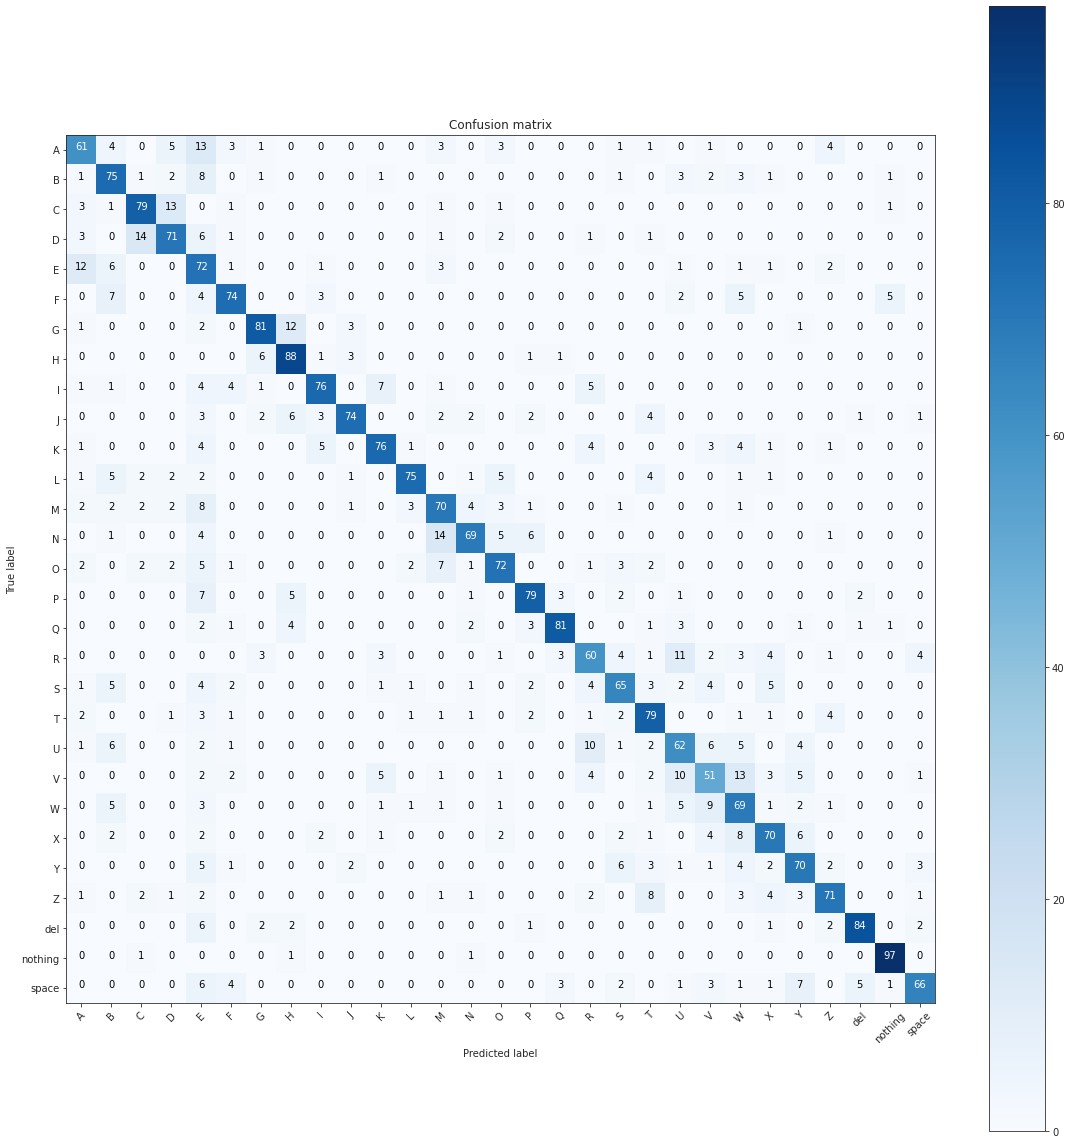

In [46]:
def fit_and_tune_svc():
    c = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
    gamma = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
    params_list = {'C': c, 'gamma': gamma}
    clf = SVC(kernel='rbf')
    clf_name = "SVM"

    return fit_and_tune(
        X_MINI_TRAIN_PCA,
        X_DEV_PCA,
        clf,
        params_list,
        clf_name,
        "with PCA",
        1,
        1)


fit_and_tune_svc()

In [75]:
CUSTOM_TEST_DIR = '../input/asl-alphabet/asl_alphabet_test/asl_alphabet_test'
TARGET_SIZE = (64, 64)
TARGET_DIMS = (64, 64, 3)  # add channel for RGB
N_LETTERS = len(LETTERS)
VALIDATION_SPLIT = 0.1
BATCH_SIZE = 64

# Model saving for easier local iterations
MODEL_DIR = '.'
MODEL_PATH = MODEL_DIR + '/cnn-model.h5'
MODEL_WEIGHTS_PATH = MODEL_DIR + '/cnn-model.weights.h5'
MODEL_SAVE_TO_DISK = getenv('KAGGLE_WORKING_DIR') != '/kaggle/working'

#print('Save model to disk? {}'.format('Yes' if MODEL_SAVE_TO_DISK else 'No'))

In [48]:
def preprocess_image(image):
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
    return sobely

def make_generator(options):
    '''Creates two generators for dividing and preprocessing data.'''
    validation_split = options.get('validation_split', 0.0)
    preprocessor = options.get('preprocessor', None)
    data_dir = options.get('data_dir', TRAIN_DIR)

    augmentor_options = {
        'samplewise_center': True,
        'samplewise_std_normalization': True,
    }
    if validation_split is not None:
        augmentor_options['validation_split'] = validation_split
    if preprocessor is not None:
        augmentor_options['preprocessing_function'] = preprocessor

    flow_options = {
        'target_size': TARGET_SIZE,
        'batch_size': BATCH_SIZE,
        'shuffle': options.get('shuffle', None),
        'subset': options.get('subset', None),
    }

    data_augmentor = ImageDataGenerator(**augmentor_options)
    return data_augmentor.flow_from_directory(data_dir, **flow_options)

In [49]:
def load_model_from_disk():
    model_file = Path(MODEL_PATH)
    model_weights_file = Path(MODEL_WEIGHTS_PATH)

    if model_file.is_file() and model_weights_file.is_file():
        print('Retrieving model from disk...')
        model = load_model(model_file.__str__())

        print('Loading CNN model weights from disk...')
        model.load_weights(model_weights_file)
        return model

    return None


CNN_MODEL = load_model_from_disk()
REPROCESS_MODEL = (CNN_MODEL is None)

print('Need to reprocess? {}'.format(REPROCESS_MODEL))

Need to reprocess? True


In [50]:
def build_model(save=False):
    print('Building model afresh...')

    model = Sequential()
    model.add(Conv2D(64, kernel_size=5, strides=1,
                     activation='relu', input_shape=TARGET_DIMS))
    model.add(Conv2D(64, kernel_size=5, strides=2, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Conv2D(128, kernel_size=4, strides=1, activation='relu'))
    model.add(Conv2D(128, kernel_size=4, strides=2, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Conv2D(256, kernel_size=4, strides=1, activation='relu'))
    model.add(Conv2D(256, kernel_size=4, strides=2, activation='relu'))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(N_LETTERS, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy', metrics=['accuracy'])
    if save:
        model.save(MODEL_PATH)

    return model
if REPROCESS_MODEL:
    CNN_MODEL = build_model(save=MODEL_SAVE_TO_DISK)

print_summary(CNN_MODEL)


Building model afresh...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 60, 64)        4864      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        102464    
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 128)       131200    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 128)       262272    
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 11, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (N

In [51]:
def make_generator_for(subset):
    '''Create a generator for the training or validation set.'''
    generator_options = dict(
        validation_split=VALIDATION_SPLIT,
        shuffle=True,
        subset=subset,
        preprocessor=preprocess_image,
    )
    return make_generator(generator_options)


def fit_model(model, train_generator, val_generator, save=False):
    '''Fit the model with the training and validation generators.'''
    history = model.fit_generator(
        train_generator, epochs=5, validation_data=val_generator)

    if save:
        model.save_weights(MODEL_WEIGHTS_PATH)

    return history

In [52]:
CNN_TRAIN_GENERATOR = make_generator_for('training')
CNN_VAL_GENERATOR = make_generator_for('validation')

def reprocess_model():
    start_time = time.time()
    history = fit_model(CNN_MODEL, CNN_TRAIN_GENERATOR,
                        CNN_VAL_GENERATOR, save=MODEL_SAVE_TO_DISK)
    print('Fitting the model took ~{:.0f} second(s).'.format(
        time.time() - start_time))
    return history


def show_cnn_model_weights():
    columns = ['Dimension 1', 'Dimension 2', 'Dimension 3', 'Dimension 4']
    return pd.DataFrame(data=[x.shape for x in CNN_MODEL.weights], columns=columns)

HISTORY = None
if REPROCESS_MODEL:
    HISTORY = reprocess_model()
show_cnn_model_weights()

Found 78300 images belonging to 29 classes.
Found 8700 images belonging to 29 classes.
Epoch 1/5
1224/1224 [==============================] - 261s 213ms/step - loss: 1.3308 - accuracy: 0.5775 - val_loss: 1.4127 - val_accuracy: 0.6149
Epoch 2/5
1224/1224 [==============================] - 143s 117ms/step - loss: 0.3677 - accuracy: 0.8758 - val_loss: 0.9369 - val_accuracy: 0.7292
Epoch 3/5
1224/1224 [==============================] - 146s 119ms/step - loss: 0.2514 - accuracy: 0.9169 - val_loss: 0.9068 - val_accuracy: 0.7457
Epoch 4/5
1224/1224 [==============================] - 140s 115ms/step - loss: 0.2011 - accuracy: 0.9353 - val_loss: 0.8366 - val_accuracy: 0.7718
Epoch 5/5
1224/1224 [==============================] - 141s 115ms/step - loss: 0.1778 - accuracy: 0.9435 - val_loss: 1.0297 - val_accuracy: 0.7169
Fitting the model took ~837 second(s).


Dimension 1  Dimension 2  Dimension 3  Dimension 4
0             5          5.0          3.0         64.0
1            64          NaN          NaN          NaN
2             5          5.0         64.0         64.0
3            64          NaN          NaN          NaN
4             4          4.0         64.0        128.0
5           128          NaN          NaN          NaN
6             4          4.0        128.0        128.0
7           128          NaN          NaN          NaN
8             4          4.0        128.0        256.0
9           256          NaN          NaN          NaN
10            4          4.0        256.0        256.0
11          256          NaN          NaN          NaN
12         2304        512.0          NaN          NaN
13          512          NaN          NaN          NaN
14          512         29.0          NaN          NaN
15           29          NaN          NaN          NaN

In [56]:
def evaluate_model(generator):
    start_time = time.time()
    evaluations = CNN_MODEL.evaluate_generator(generator)
    for i in range(len(CNN_MODEL.metrics_names)):
        print("{}: {:.2f}%".format(
            CNN_MODEL.metrics_names[i], evaluations[i] * 100))
    print('Took {:.0f} seconds to evaluate this set.'.format(
        time.time() - start_time))

    start_time = time.time()
    predictions = CNN_MODEL.predict_generator(generator)
    print('Took {:.0f} seconds to get predictions on this set.'.format(
        time.time() - start_time))

    y_pred = np.argmax(predictions, axis=1)
    y_true = generator.classes
    return dict(y_pred=y_pred, y_true=y_true)
def evaluate_validation_dataset():
    gen_options = dict(
        validation_split=0.1,
        data_dir=TRAIN_DIR,
        shuffle=False,
        subset='validation',
        preprocessor=preprocess_image,
    )
    val_gen = make_generator(gen_options)
    return evaluate_model(val_gen)


def evaluate_test_dataset():
    gen_options = dict(
        validation_split=0.0,
        data_dir=CUSTOM_TEST_DIR,
        shuffle=False,
        preprocessor=preprocess_image,
    )
    test_gen = make_generator(gen_options)
    return evaluate_model(test_gen)

In [57]:
CNN_VALIDATION_SET_EVAL = evaluate_validation_dataset()

Found 8700 images belonging to 29 classes.
loss: 102.97%
accuracy: 71.69%
Took 13 seconds to evaluate this set.
Took 13 seconds to get predictions on this set.


In [58]:
print(classification_report(**CNN_VALIDATION_SET_EVAL, target_names=LETTERS))

              precision    recall  f1-score   support

           A       0.47      1.00      0.64       300
           B       0.69      0.82      0.75       300
           C       0.99      0.86      0.92       300
           D       1.00      0.89      0.94       300
           E       0.57      0.78      0.66       300
           F       1.00      0.76      0.86       300
           G       1.00      0.84      0.91       300
           H       0.90      0.99      0.94       300
           I       0.79      0.23      0.35       300
           J       1.00      0.92      0.96       300
           K       1.00      0.83      0.91       300
           L       0.96      0.44      0.60       300
           M       0.57      0.74      0.64       300
           N       0.63      0.62      0.63       300
           O       0.96      0.57      0.72       300
           P       0.99      0.89      0.94       300
           Q       0.93      0.73      0.82       300
           R       0.57    

Confusion matrix, without normalization


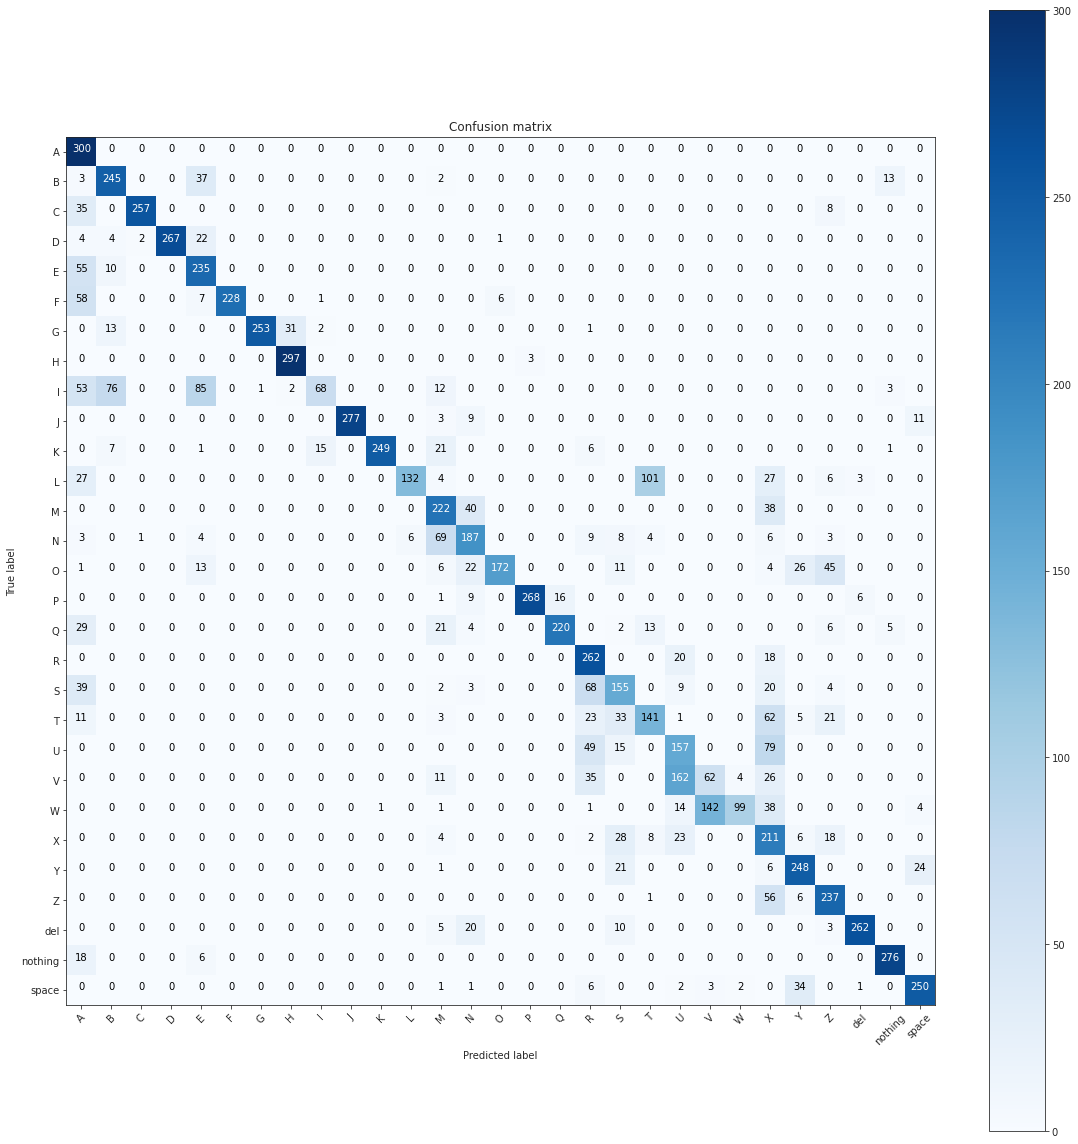

In [63]:
with sns.axes_style('ticks'):
    plot_confusion_matrix_with_default_options(
        **CNN_VALIDATION_SET_EVAL, classes=LETTERS)

In [64]:
def fit_and_tune_random_forest():
    clf = RandomForestClassifier()
    clf_name = "Random_Forest"
    params_list = {
        'n_estimators': [10, 20, 50, 100, 200, 700],
        'max_features': ['auto', 'sqrt', 'log2']
    }

    return fit_and_tune(
        X_MINI_TRAIN_PCA,
        X_DEV_PCA,
        clf,
        params_list,
        clf_name,
        "with PCA",
        0,
        0)


fit_and_tune_random_forest()

Tuning parameters for with PCA for classifier Random_Forest
Best paramaters: {'max_features': 'auto', 'n_estimators': 700}
Best grid score: 0.634
Dev accuracy:  68.55172413793103


In [62]:
def run_naive_bayes(train, dev):
    clf = BernoulliNB()
    params_list = {'alpha': [0.0001, 0.001, 0.01, 1, 10, 100]}
    clf_name = "Bernoulli NB"
    fit_and_tune(train, dev, clf, params_list, clf_name, "Contoured data", 0, 0)
    return


run_naive_bayes(X_IMAGE_MINI_TRAIN, X_IMAGE_DEV)

Tuning parameters for Contoured data for classifier Bernoulli NB
Best paramaters: {'alpha': 0.01}
Best grid score: 0.430
Dev accuracy:  46.310344827586206
